Practising Time Series forecasting with reference to:
- https://courses.analyticsvidhya.com/courses/creating-time-series-forecast-using-python?utm_source=blog&utm_medium=TimeSeriesForecastComprehensivearticle
- https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/

In [2]:
import pandas as pd          
import numpy as np               # For mathematical calculations 
import matplotlib.pyplot as plt  # For plotting graphs 
from datetime import datetime    # To access datetime 
from pandas import Series        # To work on series 
%matplotlib inline 
import warnings                   # To ignore the warnings warnings.filterwarnings("ignore")

In [3]:
train=pd.read_csv("Train_SU63ISt.csv") 
test=pd.read_csv("Test_0qrQsBZ.csv")

train_original=train.copy() 
test_original=test.copy()

In [4]:
train.columns, test.columns

(Index(['ID', 'Datetime', 'Count'], dtype='object'),
 Index(['ID', 'Datetime'], dtype='object'))

In [5]:
train.shape, test.shape

((18288, 3), (5112, 2))

In [6]:
train.head(3)

,ID,Datetime,Count
0,0,25-08-2012 00:00,8
1,1,25-08-2012 01:00,2
2,2,25-08-2012 02:00,6


In [7]:
#Convert object to DateTime
train['Datetime'] = pd.to_datetime(train.Datetime,format='%d-%m-%Y %H:%M') 
test['Datetime'] = pd.to_datetime(test.Datetime,format='%d-%m-%Y %H:%M') 
test_original['Datetime'] = pd.to_datetime(test_original.Datetime,format='%d-%m-%Y %H:%M') 
train_original['Datetime'] = pd.to_datetime(train_original.Datetime,format='%d-%m-%Y %H:%M')

In [8]:
#Extract hour, day, month and year from Datetime
for i in (train, test, test_original, train_original):    #for each row
    i['year']=i.Datetime.dt.year 
    i['month']=i.Datetime.dt.month 
    i['day']=i.Datetime.dt.day
    i['Hour']=i.Datetime.dt.hour 

In [9]:
#need to create a new column to indicate whether weekend or not
train['day of week']=train['Datetime'].dt.dayofweek 

In [10]:
#day 5 and 6 are weekends
#Assign 1 if day is 5 or 6, otherwise 0

temp = train['Datetime']                     #store DateTime column in a var temp
def applyer(row):
    if row.dayofweek == 5 or row.dayofweek == 6:
        return 1
    else:
        return 0 

temp2 = train['Datetime'].apply(applyer)     #apply function to entire DateTime column
train['weekend']=temp2                       #store weekend column in a var temp2

In [11]:
train.head(3)

,ID,Datetime,Count,year,month,day,Hour,day of week,weekend
0,0,2012-08-25 00:00:00,8,2012,8,25,0,5,1
1,1,2012-08-25 01:00:00,2,2012,8,25,1,5,1
2,2,2012-08-25 02:00:00,6,2012,8,25,2,5,1


C:\Users\Hong.Wen.Tai\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


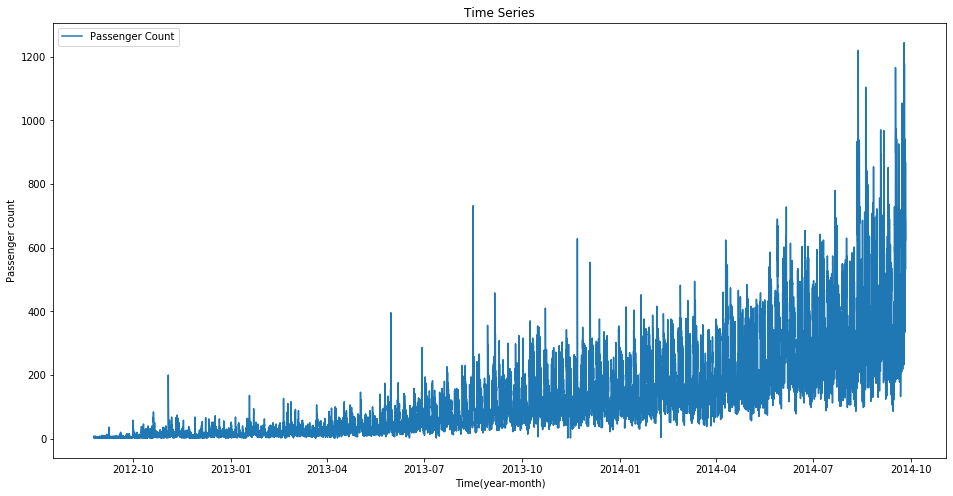

In [12]:
#Plotting chart with time period as x-axis and passenger count as y-axis

train.index = train['Datetime'] # indexing the Datetime to get the time period on the x-axis. 
df=train.drop('ID',1)           # drop ID variable to get only the Datetime on x-axis. 
ts = df['Count']                #y-axis
plt.figure(figsize=(16,8)) 
plt.plot(ts, label='Passenger Count') 
plt.title('Time Series') 
plt.xlabel("Time(year-month)") 
plt.ylabel("Passenger count") 
plt.legend(loc='best')

Therefore, can use an increasing trend in the series ie. number of count is increasing with respect to time. 
Can also see spikes in passenger count at certain points, traffic may be high on certain days.

## Validating hypotheses with Exploratory Analysis

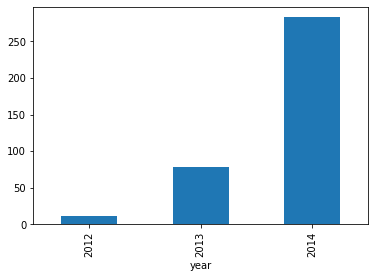

In [13]:
#Validate hypothesis that traffic increases with year
#visualize passenger count by year
train.groupby('year')['Count'].mean().plot.bar()

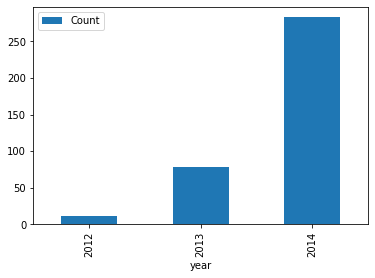

In [14]:
train.pivot_table(index="year",values = "Count").plot(kind="bar")

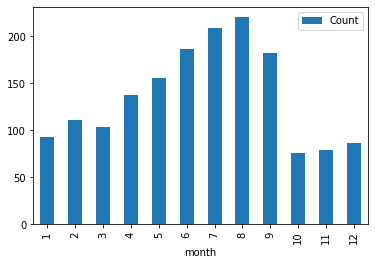

In [15]:
#Validate hypothesis that traffic will increase from May to Dec
train.pivot_table(index = "month", values ="Count").plot(kind="bar")

Notice that Oct to Dec has extraodinarily low passenger count

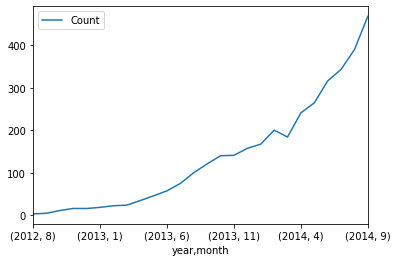

In [16]:
#Visualize all months from 2012 to 2014
train.pivot_table(index = ["year","month"], values ="Count").plot(kind="line")

We notice that data from Oct to Dec in 2014 is missing. Values in 2014 also skew the data due to its high value

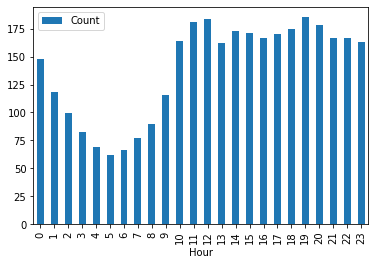

In [17]:
#Validate hypothesis that traffic will be more during peak hours
train.pivot_table(index = "Hour", values = "Count").plot(kind="bar")

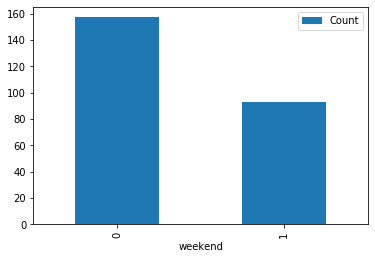

In [18]:
#Validate hypothesis that traffic will be more during weekdays
train.pivot_table(index = "weekend", values = "Count").plot(kind="bar")

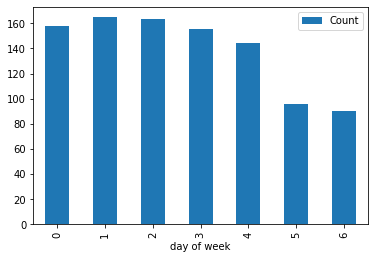

In [19]:
#Visualize traffic for day of the week
train.pivot_table(index = "day of week", values = "Count").plot(kind="bar")

## Preparing for modeling

In [20]:
#drop ID column since not used in modeling
train=train.drop('ID',1)

In [21]:
train.Timestamp = pd.to_datetime(train.Datetime,format='%d-%m-%Y %H:%M') 
train.index = train.Timestamp 

C:\Users\Hong.Wen.Tai\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """Entry point for launching an IPython kernel.


In [22]:
train.head(3)

,Datetime,Count,year,month,day,Hour,day of week,weekend
Datetime,,,,,,,,
2012-08-25 00:00:00,2012-08-25 00:00:00,8,2012,8,25,0,5,1
2012-08-25 01:00:00,2012-08-25 01:00:00,2,2012,8,25,1,5,1
2012-08-25 02:00:00,2012-08-25 02:00:00,6,2012,8,25,2,5,1


In [23]:
hourly = train.resample('H').mean()
daily = train.resample('D').mean() 
weekly = train.resample('W').mean() 
monthly = train.resample('M').mean()

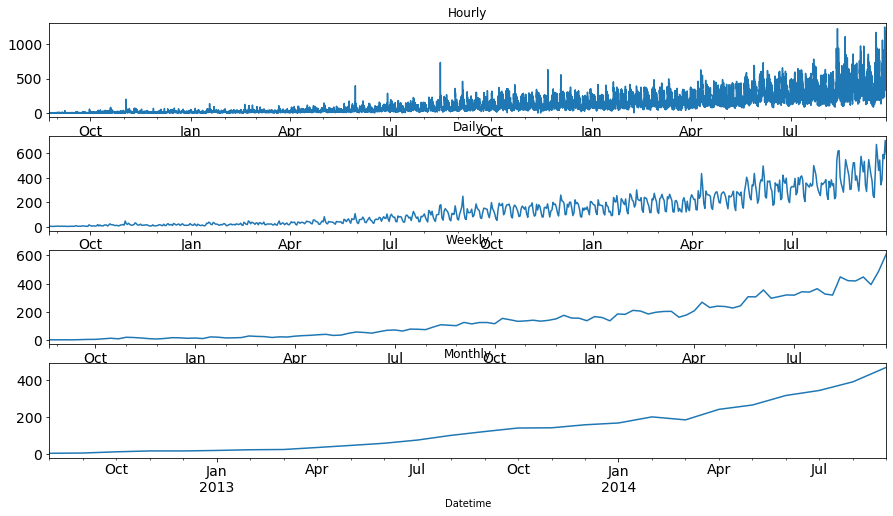

In [24]:
fig, axs = plt.subplots(4,1) 
hourly.Count.plot(figsize=(15,8), title= 'Hourly', fontsize=14, ax=axs[0]) 
daily.Count.plot(figsize=(15,8), title= 'Daily', fontsize=14, ax=axs[1]) 
weekly.Count.plot(figsize=(15,8), title= 'Weekly', fontsize=14, ax=axs[2]) 
monthly.Count.plot(figsize=(15,8), title= 'Monthly', fontsize=14, ax=axs[3]) 

In [25]:
test.Timestamp = pd.to_datetime(test.Datetime,format='%d-%m-%Y %H:%M') 
test.index = test.Timestamp   
test = test.resample('D').mean()

train = train.resample('D').mean()          #use daily series as index

C:\Users\Hong.Wen.Tai\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """Entry point for launching an IPython kernel.


In [26]:
train.head(3)

,Count,year,month,day,Hour,day of week,weekend
Datetime,,,,,,,
2012-08-25,3.166667,2012.0,8.0,25.0,11.5,5.0,1.0
2012-08-26,3.666667,2012.0,8.0,26.0,11.5,6.0,1.0
2012-08-27,2.583333,2012.0,8.0,27.0,11.5,0.0,0.0


## Modeling

In [27]:
Train=train.loc['2012-08-25':'2014-06-24'] 
valid=train.loc['2014-06-25':'2014-09-25']

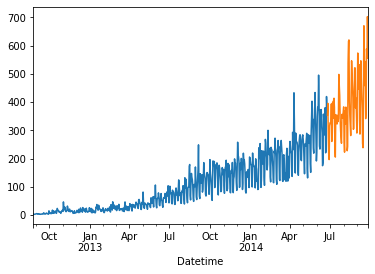

In [28]:
#Visualizing training and validation data
Train.Count.plot()
valid.Count.plot()

## 1) Naive Approach

In [29]:
#Naive approach: expected value takes last observed value
dd = np.asarray(Train.Count)   #make a numpy array out of Counts in Training set

In [30]:
dd[0] #first element of array is 3.16, we need to get last element

3.1666666666666665

In [31]:
dd[len(dd)-1]    

372.1666666666667

We need to assign this value to all values in the valid set.

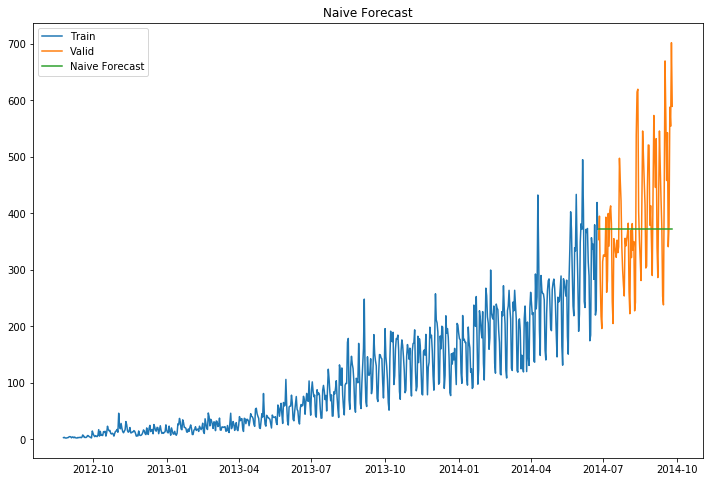

In [32]:
y_hat = valid.copy()
y_hat['naive']= dd[len(dd)-1]    
plt.figure(figsize=(12,8)) 
plt.plot(Train.index, Train['Count'], label='Train') 
plt.plot(valid.index,valid['Count'], label='Valid') 
plt.plot(y_hat.index,y_hat['naive'], label='Naive Forecast') 
plt.legend(loc='best') 
plt.title("Naive Forecast") 
plt.show()

In [33]:
#use RMSE to check accuracy of model on validation set
from sklearn.metrics import mean_squared_error 
from math import sqrt 
rms = sqrt(mean_squared_error(valid.Count, y_hat.naive)) 
print(rms)

111.79050467496724


## 2) Moving Average

In [34]:
#Moving average: expected value takes average of last few points
Train['Count'].rolling(10).mean()        #rolling mean of window length of 10

Datetime
2012-08-25           NaN
2012-08-26           NaN
2012-08-27           NaN
2012-08-28           NaN
2012-08-29           NaN
2012-08-30           NaN
2012-08-31           NaN
2012-09-01           NaN
2012-09-02           NaN
2012-09-03      3.475000
2012-09-04      3.433333
2012-09-05      3.500000
2012-09-06      3.658333
2012-09-07      3.700000
2012-09-08      3.866667
2012-09-09      3.841667
2012-09-10      3.783333
2012-09-11      3.558333
2012-09-12      3.416667
2012-09-13      3.266667
2012-09-14      3.341667
2012-09-15      3.291667
2012-09-16      3.166667
2012-09-17      3.266667
2012-09-18      3.633333
2012-09-19      4.008333
2012-09-20      4.091667
2012-09-21      4.225000
2012-09-22      4.200000
2012-09-23      4.325000
                 ...    
2014-05-26    282.175000
2014-05-27    297.325000
2014-05-28    325.608333
2014-05-29    331.358333
2014-05-30    325.600000
2014-05-31    304.441667
2014-06-01    289.408333
2014-06-02    294.608333
2014-06-03    30

In [35]:
Train['Count'].rolling(10).mean().iloc[-1]   #rolling mean of window length of 10, starting with the last position in Training set

313.0333333333333

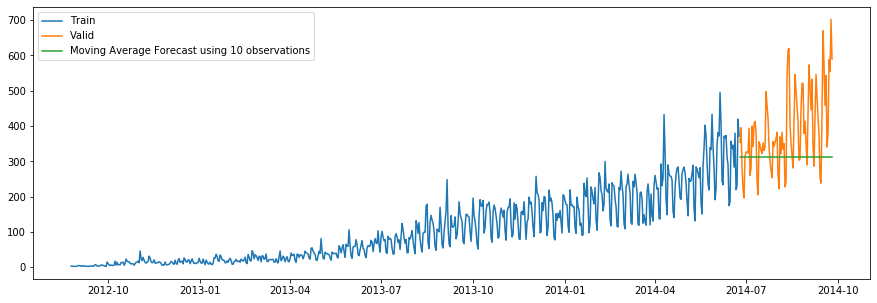

In [36]:
y_hat_avg = valid.copy() 
y_hat_avg['moving_avg_forecast'] = Train['Count'].rolling(10).mean().iloc[-1] # average of last 10 observations. 
plt.figure(figsize=(15,5)) 
plt.plot(Train['Count'], label='Train') 
plt.plot(valid['Count'], label='Valid') 
plt.plot(y_hat_avg['moving_avg_forecast'], label='Moving Average Forecast using 10 observations') 
plt.legend(loc='best') 
plt.show()

In [37]:
rms = sqrt(mean_squared_error(valid.Count, y_hat_avg.moving_avg_forecast)) 
print(rms)

134.23733308950264


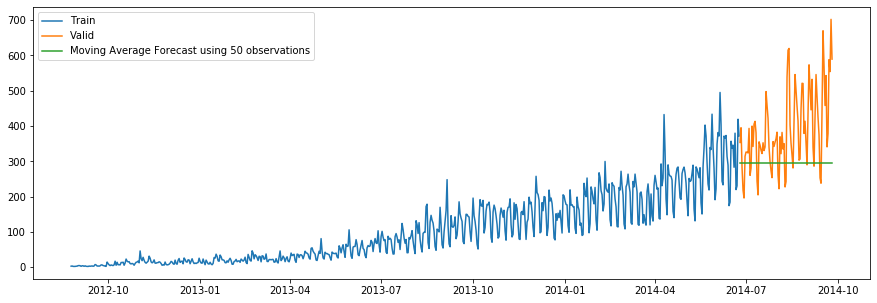

In [38]:
y_hat_avg['moving_avg_forecast'] = Train['Count'].rolling(50).mean().iloc[-1] # average of last 50 observations. 
plt.figure(figsize=(15,5)) 
plt.plot(Train['Count'], label='Train') 
plt.plot(valid['Count'], label='Valid') 
plt.plot(y_hat_avg['moving_avg_forecast'], label='Moving Average Forecast using 50 observations') 
plt.legend(loc='best') 
plt.show()

In [39]:
rms = sqrt(mean_squared_error(valid.Count, y_hat_avg.moving_avg_forecast)) 
print(rms)

144.19175679986802


Therefore, error rate increases as the number of observations we take for rolling average increases.

## 3) Simple Exponential Smoothing

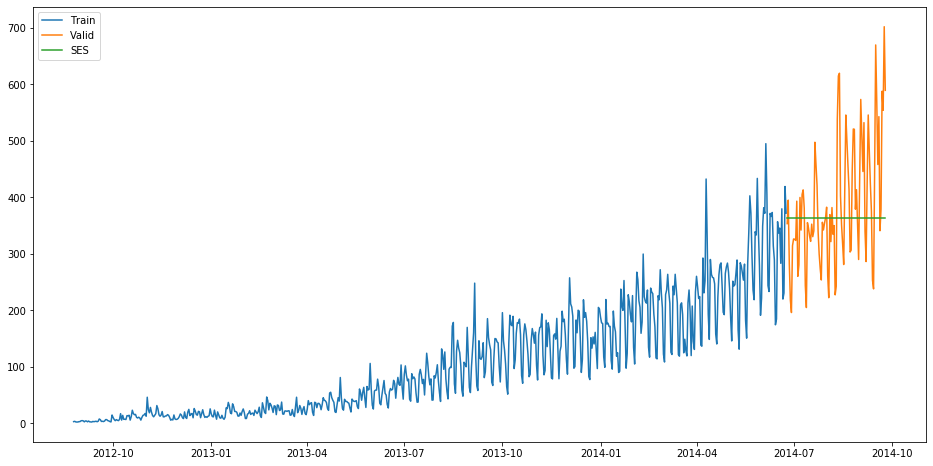

In [40]:
#assigning larger weights to recent values and lesser weight to old values
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt 
y_hat_avg = valid.copy() 
fit2 = SimpleExpSmoothing(np.asarray(Train['Count'])).fit(smoothing_level=0.6,optimized=False) 
y_hat_avg['SES'] = fit2.forecast(len(valid)) 
plt.figure(figsize=(16,8)) 
plt.plot(Train['Count'], label='Train') 
plt.plot(valid['Count'], label='Valid') 
plt.plot(y_hat_avg['SES'], label='SES') 
plt.legend(loc='best') 
plt.show()

In [41]:
rms = sqrt(mean_squared_error(valid.Count, y_hat_avg.SES)) 
print(rms)

113.43708111884514


## 4) Holt's Linear Trend Model

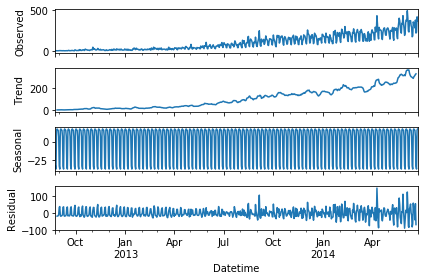

In [42]:
#exponential smoothing applied to both level and trend
#let's visualize the trend, seasonality and error in series
import statsmodels.api as sm 
sm.tsa.seasonal_decompose(Train.Count).plot() 
result = sm.tsa.stattools.adfuller(train.Count) 
plt.show()

After decomposing the time series, we can see that dataset follows an icnreasing trend. Therefore can use Holt's method

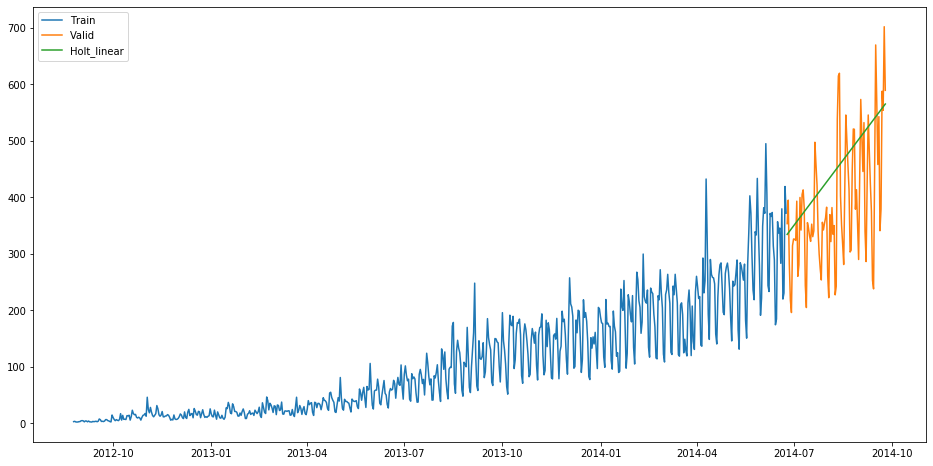

In [43]:
y_hat_avg = valid.copy() 
fit1 = Holt(np.asarray(Train['Count'])).fit(smoothing_level = 0.3,smoothing_slope = 0.1) 
y_hat_avg['Holt_linear'] = fit1.forecast(len(valid))   #predict on validation set

plt.figure(figsize=(16,8)) 
plt.plot(Train['Count'], label='Train') 
plt.plot(valid['Count'], label='Valid') 
plt.plot(y_hat_avg['Holt_linear'], label='Holt_linear') 
plt.legend(loc='best') 
plt.show()

In [44]:
rms = sqrt(mean_squared_error(valid.Count, y_hat_avg.Holt_linear)) 
print(rms)

112.94278345314041


In [45]:
submission=pd.read_csv("submission.csv")

In [46]:
predict=fit1.forecast(len(test))         #prediction on test set

In [47]:
test['prediction']=predict              #store daily predictions in column of test set

In [48]:
#since they are daily predictions, need to convert to hourly
#1. Calculate ratio of passenger count for ea hour of every day
#2. Find average ratio of passenger count for every hour, we will get 24 ratios
#3. Divide daily prediction with hourly rate to calculate hourly predictions

## 5) Holt's Winter model

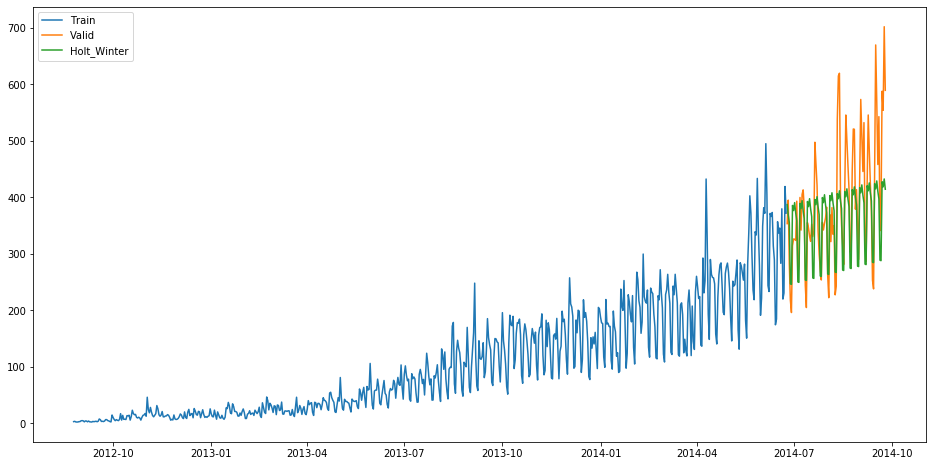

In [49]:
#exponential smoothing to level, trend and seasonality
y_hat_avg = valid.copy() 
fit1 = ExponentialSmoothing(np.asarray(Train['Count']) ,seasonal_periods=7 ,trend='add', seasonal='add',).fit()   #add trend, add seasonality
y_hat_avg['Holt_Winter'] = fit1.forecast(len(valid))      #predict on validation set

plt.figure(figsize=(16,8)) 
plt.plot( Train['Count'], label='Train') 
plt.plot(valid['Count'], label='Valid') 
plt.plot(y_hat_avg['Holt_Winter'], label='Holt_Winter') 
plt.legend(loc='best') 
plt.show()

In [50]:
rms = sqrt(mean_squared_error(valid.Count, y_hat_avg.Holt_Winter)) 
print(rms)


82.38041226792582


## 6. ARIMA model

In [51]:
#specified by 3 parameteres p, d and q
# p: order of the autoregressive model (no. of time lags)
# d: degree of differencing (no of times the data have past values subtracted)
# q: order of moving average model

#Arima forecasting for stationary time series: just like linear equation

#Need to make time series stationary to make variables independent, to get more info

#Use Dickey Fuller test to check stationarity
#If test statistic less than critical value, reject null hypothesis and say series is stationary

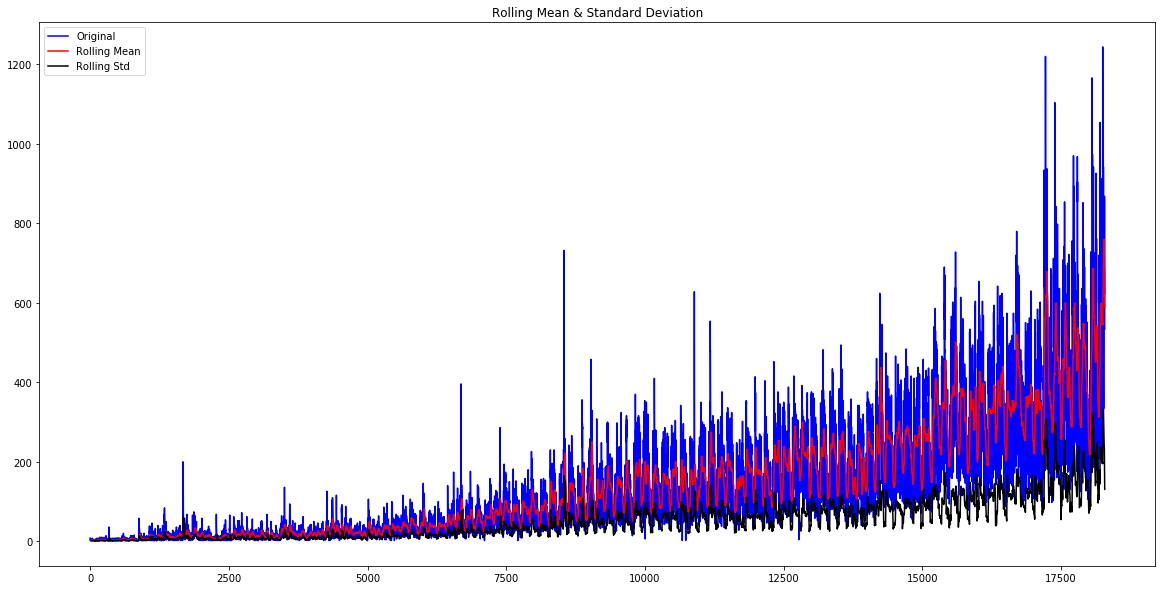

Results of Dickey-Fuller Test:
Test Statistic                    -4.456561
p-value                            0.000235
#Lags Used                        45.000000
Number of Observations Used    18242.000000
Critical Value (1%)               -3.430709
Critical Value (5%)               -2.861698
Critical Value (10%)              -2.566854
dtype: float64


In [52]:
from statsmodels.tsa.stattools import adfuller 
def test_stationarity(timeseries):
        #Determing rolling statistics
    rolmean = timeseries.rolling(24).mean()
    rolstd = timeseries.rolling(24).std()
    
        #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
        #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

from matplotlib.pylab import rcParams 
rcParams['figure.figsize'] = 20,10
test_stationarity(train_original['Count'])

Let's try the ARIMA model on a different dataset, Shampoo Sales.

Month
1901-01-01    266.0
1901-02-01    145.9
1901-03-01    183.1
1901-04-01    119.3
1901-05-01    180.3
Name: Sales, dtype: float64


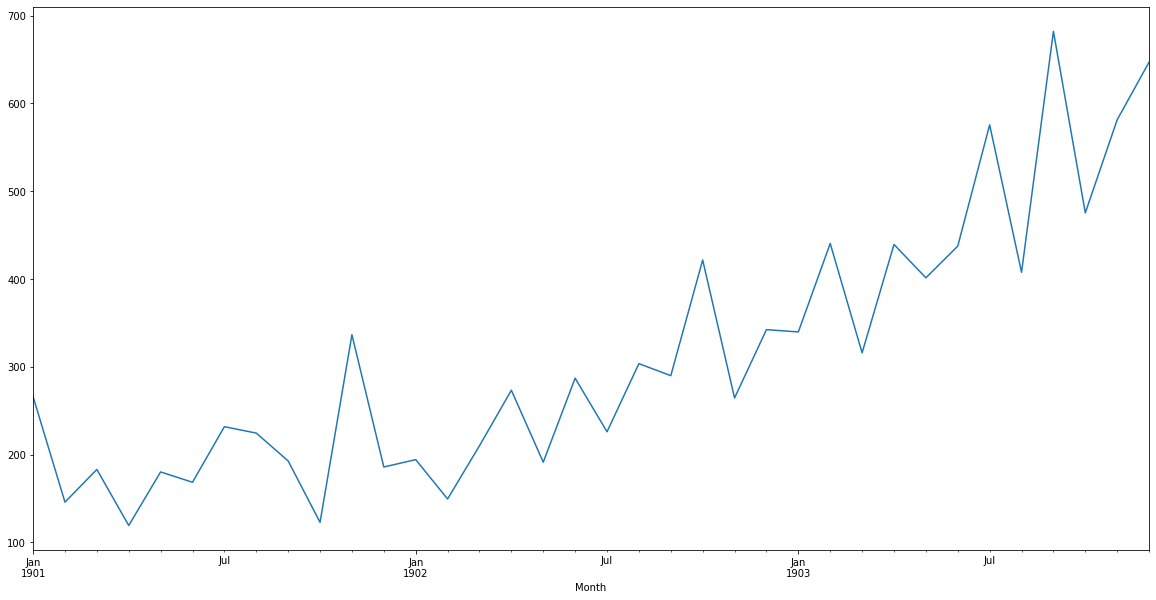

In [55]:
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')
 
series = pd.read_csv('shampoo.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
print(series.head())
series.plot()
plt.show()

Shampoo Sales dataset has a clear trend.

This suggests that the time series is not stationary and will require differencing to make it stationary, at least a difference order of 1.

Let's take a quick look at an autocorrelation plot of the time series:

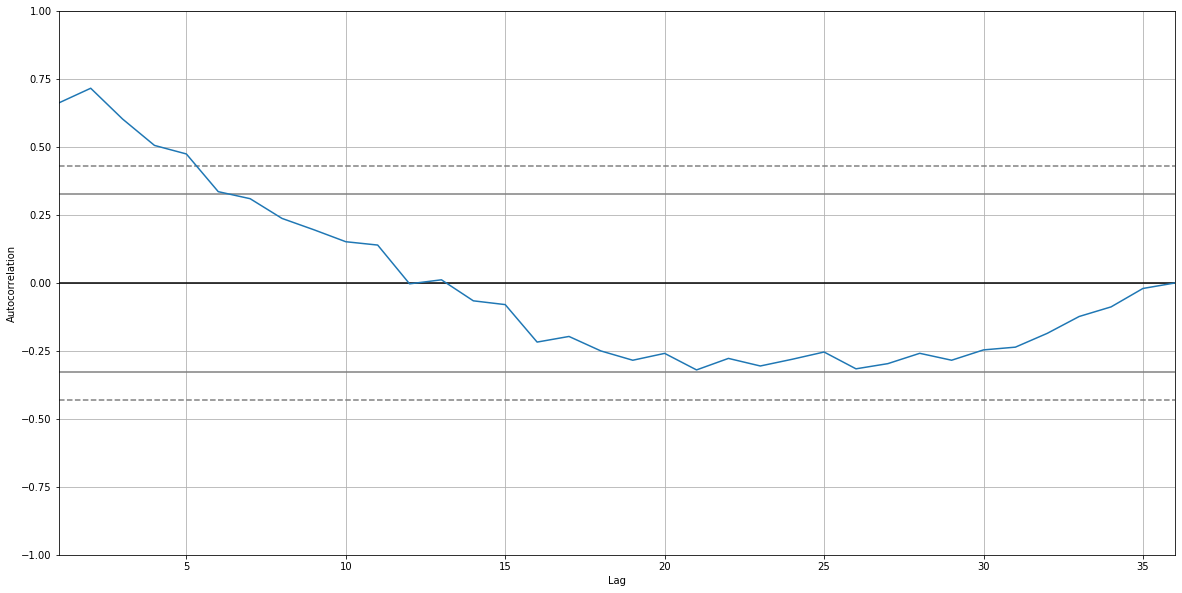

In [58]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(series)
plt.show()

We can observe there is a positive correlation for first 12 lags, that is perhaps significant for the first 5 lags. Thus, a good starting point for the AR parameter of the model may be 5.

Let's now create an ARIMA model using the statsmodels library:
1. Define the model by calling ARIMA() and passing in the p, d, and q parameters.
2. The model is prepared on the training data by calling the fit() function.
3. Predictions can be made by calling the predict() function and specifying the index of the time or times to be predicted.

In [62]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(series, order=(5,1,0))    #set lag value to 5 for autoregression, use difference order of 1 to make time series stationary, use moving average model of 0.
model_fit = model.fit(disp=0)           #disp = 0 to turn debug info off
print(model_fit.summary())

C:\Users\Hong.Wen.Tai\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Hong.Wen.Tai\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                D.Sales   No. Observations:                   35
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -196.170
Method:                       css-mle   S.D. of innovations             64.241
Date:                Thu, 12 Sep 2019   AIC                            406.340
Time:                        19:30:26   BIC                            417.227
Sample:                    02-01-1901   HQIC                           410.098
                         - 12-01-1903                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            12.0649      3.652      3.304      0.003       4.908      19.222
ar.L1.D.Sales    -1.1082      0.183     -6.063      0.000      -1.466      -0.750
ar.L2.D.Sales    -0.6203      0.282     

Let's now make a rolling forecast using our ARIMA model. A rolling forecast is required given the dependence on observations in prior timesteps for differencing and the ARIMA model.
- crude way to perform rolling forecast: recreate ARIMA model after ea new observation is received
- We manually track all observations in a list called history that is seeded with training data and to which new observations are appended each iteration

predicted=349.117692, expected=342.300000
predicted=306.512866, expected=339.700000
predicted=387.376465, expected=440.400000
predicted=348.154144, expected=315.900000
predicted=386.308801, expected=439.300000
predicted=356.082088, expected=401.300000
predicted=446.379471, expected=437.400000
predicted=394.737288, expected=575.500000
predicted=434.915413, expected=407.600000
predicted=507.923472, expected=682.000000
predicted=435.482761, expected=475.300000
predicted=652.743901, expected=581.300000
predicted=546.343472, expected=646.900000
Test MSE: 6958.326


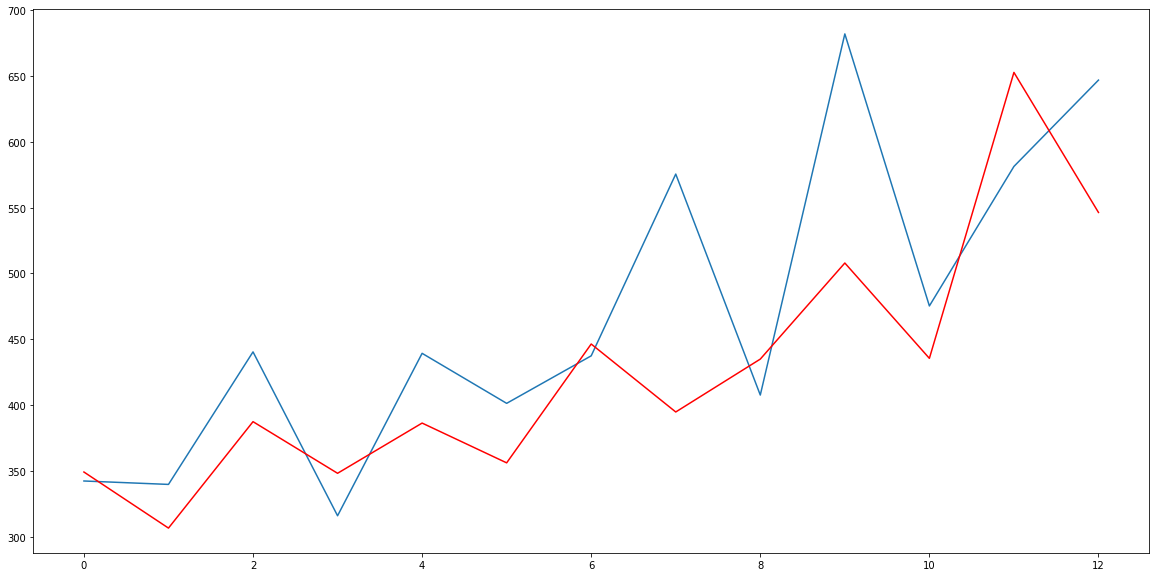

In [65]:
from sklearn.metrics import mean_squared_error

X = series.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()